# testing ML based forecasting of global water watch timeseries using autogluon
https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quickstart.html

# import libaries for gww 

In [3]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import datetime

from dateutil.relativedelta import relativedelta
from scipy import stats
from shapely.geometry import shape, box, mapping

base_url = "https://api.globalwaterwatch.earth"
start = datetime.datetime(2021, 1, 1)
stop = datetime.datetime(2022, 1, 1)

# define helper functions to use with gww api

In [4]:
def to_geopandas(data):
    """
    Ingests list of reservoirs and converts into a geopandas GeoDataFrame for further analyses
    
    """
    geoms = [shape(f["geometry"]) for f in data]
    props = [{**f["properties"], **{"id": f["id"]}} for f in data]
    return gpd.GeoDataFrame(props, geometry=geoms, crs=4326)

def get_reservoirs(skip=1, limit=5, base_url=base_url):
    """
    Gets reservoirs from API. Return dict with IDs.
    
    """
    url = f"{base_url}/reservoir"
    params = {
        "skip": skip,
        "limit": limit,
    }
    return requests.get(url, params=params)


def get_reservoir(reservoir_id):
    """
    Get reservoir (geometry and props) by ID
    """
    url = f"{base_url}/reservoir/{reservoir_id}"
    return requests.get(url)
    

def get_reservoirs_by_geom(geom, base_url=base_url):
    """
    Gets reservoirs from API. Return dict with IDs.
    
    """
    url = f"{base_url}/reservoir/geometry"
    # do post request to end point with the serialized geometry as post data
    return requests.post(url, data=geom)


def get_reservoir_ts(reservoir_id, start=start, stop=stop):
    """
    Get time series data for reservoir with given ID
    """
    url = f"{base_url}/reservoir/{reservoir_id}/ts"
    params = {
        "start": start.strftime("%Y-%m-%dT%H:%M:%S"),
        "stop": stop.strftime("%Y-%m-%dT%H:%M:%S")
    }
    return requests.get(url, params=params)
    
    
def plot_features_map(feats, ax=None, figsize=(20, 13), tiles=None, zoom_level=1, tiles_kwargs={}, **kwargs):
    """
    add a set of features to a GeoAxes map
    """
    if ax is None:
        f = plt.figure(figsize=figsize)
        if tiles is not None:
            tiler = getattr(cimgt, tiles)(**tiles_kwargs)
            crs = tiler.crs
        else:
            crs = ccrs.PlateCarree()
        # make point collection
        ax = plt.subplot(projection=crs)
        if tiles is not None:
            ax.add_image(tiler, zoom_level, zorder=1)
            feats.to_crs(3857).plot(ax=ax, zorder=2, **kwargs)
        else:
            feats.plot(ax=ax, **kwargs)
    return ax

# retrieve data for reservoir id

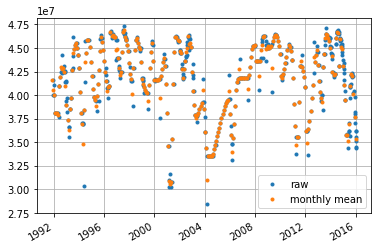

In [5]:
def to_timeseries(data, name=None):
    """
    Convert raw list of jsons to organized pandas.DataFrame
    """
    if name is None:
        name = "area"

    t_index = [p["t"] for p in data]
    v = [{name: p["value"]} for p in data]
    pd.DatetimeIndex(t_index)
    return pd.DataFrame(
        v,
        index=pd.DatetimeIndex(t_index)
    )


# input parameters to get timeseries data for a specific reservoir
s = datetime.datetime(1991, 11, 29)
e = datetime.datetime(2016, 1, 18)
reservoir_id = 87663 # https://www.globalwaterwatch.earth/reservoir/87663

# retrieve data for specific reservoir
r = get_reservoir_ts(reservoir_id, start=s, stop=e)

# again, raw data are not easy to process, so we have a nice function to convert to pandas
df = to_timeseries(r.json())
ax = plt.subplot(111)
df.plot(ax=ax, linewidth=0., marker=".", label="raw")

# let's also compute the monthly means so that we can more easily compare against other reservoirs
df_mean = df.resample("MS").mean()
df_mean.plot(ax=ax, marker=".", linewidth=0, label="monthly mean")
ax.grid()
ax.legend(["raw", "monthly mean"])



# first autogluon test
https://auto.gluon.ai/stable/index.html

Note installation issues with Apple M1: https://github.com/autogluon/autogluon/issues/1242

Install instructions for Apple M1: https://github.com/autogluon/autogluon/issues/1242#issuecomment-1285276870; https://github.com/autogluon/autogluon/blob/master/full_install.sh

## import libraries for autogluon

In [6]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
# need to conda install ipykernel
#import autogluon

ModuleNotFoundError: No module named 'autogluon'

In [ ]:
df = pd.DataFrame(data=(df.index,df.area.values),index=['date','area']).T
df


In [ ]:
# get era5 data